In [1]:
import os
import json
import matplotlib.pyplot as plt
import re
import seaborn as sns
import itertools
import math
import numpy as np

In [2]:
def concat_metrics(folder_path: str):
    merged_data = {}

    for checkpoint in os.listdir(folder_path):
        if checkpoint.startswith("checkpoint-"):
            checkpoint_id = checkpoint.replace("checkpoint-", "")
            checkpoint_path = os.path.join(folder_path, checkpoint)

            for file in os.listdir(checkpoint_path):
                if "metrics" in file:
                    with open(os.path.join(checkpoint_path, file), "r") as f:
                        data = json.load(f)
                        merged_data[checkpoint_id] = data  # store under checkpoint_id

    return merged_data

def plot_faithfulness(folder_paths, labels=None, total_epochs=None, y_max=None):
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]

    if labels is None:
        labels = [f'Run {i}' for i in range(len(folder_paths))]

    plt.figure(figsize=(10, 6))

    for folder_path, label in zip(folder_paths, labels):
        data = concat_metrics(folder_path)
        keys = sorted(data.keys(), key=lambda x: int(x))
        steps = [int(k) for k in keys]

        # Map to epochs if total_epochs is given
        if total_epochs:
            min_step, max_step = min(steps), max(steps)
            epochs = [
                ((s - min_step) / (max_step - min_step)) * total_epochs
                for s in steps
            ]
        else:
            epochs = steps

        model_accuracies = [data[k].get('percentage_performance_kl', 0) for k in keys]

        plt.plot(epochs, model_accuracies, marker='o', label=label)

    plt.xlabel('Epoch' if total_epochs else 'Run ID')
    plt.ylabel('Faithfulness Accuracy')
    plt.title('Model Faithfulness Across Runs')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # Force y-axis start at 0, optionally set max
    if y_max is not None:
        plt.ylim(0, y_max)
    else:
        plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()

In [62]:
import matplotlib.pyplot as plt
import itertools

def plot_accuracies(folder_paths, titles=None, total_epochs=None, labels=None, save_path=None):
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]

    if titles is None:
        titles = [f'Run {i+1}' for i in range(len(folder_paths))]

    fig, axes = plt.subplots(2,1 , figsize=(8, 8))
    colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for folder_path, title in zip(folder_paths, titles):
        data = concat_metrics(folder_path)
        keys = sorted(data.keys(), key=lambda x: int(x))
        steps = [int(k) for k in keys]

        if total_epochs:
            min_step, max_step = min(steps), max(steps)
            epochs = [((s - min_step) / (max_step - min_step)) * total_epochs for s in steps]
        else:
            epochs = steps

        model_acc = [data[k].get('model_accuracy', 0) for k in keys]
        graph_acc = [data[k].get('graph_accuracy', 0) for k in keys]
        color = next(colors)

        axes[0].plot(epochs, model_acc, label=title, color=color, linewidth=1.5, marker='o', markersize=5, alpha=0.9)
        axes[1].plot(epochs, graph_acc, label=title, color=color, linewidth=1.5, marker='o', markersize=5, alpha=0.9)

    axes[0].set_xlabel('Epoch', fontsize=11)
    axes[0].set_ylabel('Model Accuracy', fontsize=11)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].legend()

    axes[1].set_xlabel('Epoch', fontsize=11)
    axes[1].set_ylabel('Circuit Accuracy', fontsize=11)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].legend()
    
    fig.suptitle('AddBase Variants (1.2 Epochs)', fontsize=12, y=0.97)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='pdf', dpi=600)
    plt.show()


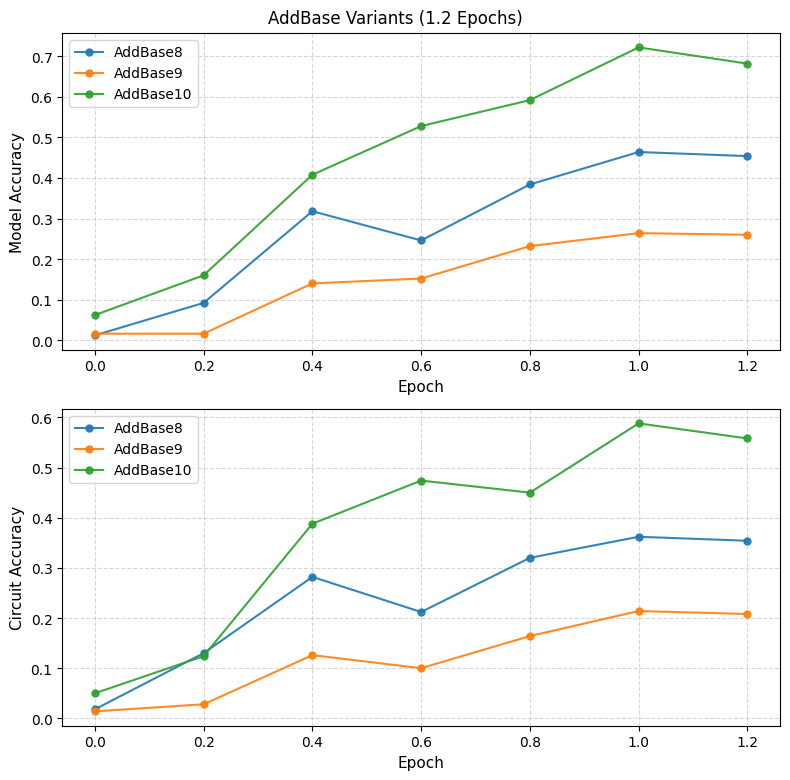

In [ ]:
paths = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase8',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase9',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase10']
plot_accuracies(paths, 
              total_epochs=1.2,
              titles = ['AddBase8','AddBase9','AddBase10'],save_path = 'addbase_model_accuracy_1_2.pdf')

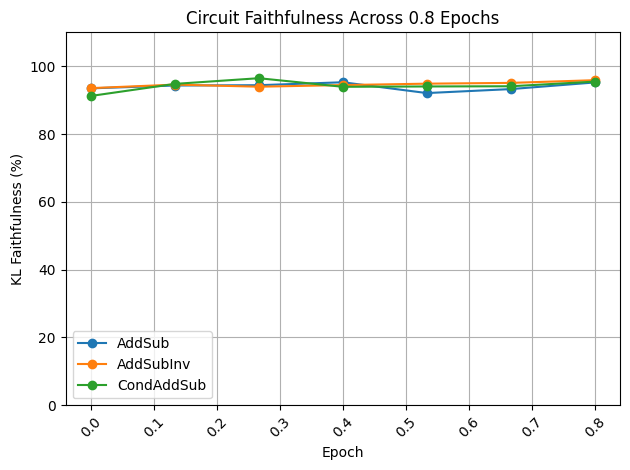

In [23]:
def plot_faithfulness(folder_paths, labels=None, total_epochs=None, y_max=None, save_path=None):
    if isinstance(folder_paths, str):
        folder_paths = [folder_paths]

    if labels is None:
        labels = [f'Run {i}' for i in range(len(folder_paths))]

    # plt.figure(figsize=(8, 6))

    for folder_path, label in zip(folder_paths, labels):
        data = concat_metrics(folder_path)
        keys = sorted(data.keys(), key=lambda x: int(x))
        steps = [int(k) for k in keys]

        if total_epochs:
            min_step, max_step = min(steps), max(steps)
            epochs = [
                ((s - min_step) / (max_step - min_step)) * total_epochs
                for s in steps
            ]
        else:
            epochs = steps

        model_accuracies = [data[k].get('percentage_performance_kl', 0) for k in keys]

        plt.plot(epochs, model_accuracies, marker='o', label=label)

    plt.xlabel('Epoch' if total_epochs else 'Run ID')
    plt.ylabel('KL Faithfulness (%)')
    plt.title('Circuit Faithfulness Across 0.8 Epochs')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    if y_max is not None:
        plt.ylim(0, y_max)
    else:
        plt.ylim(bottom=0)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf', dpi=600)
    plt.show()

paths = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/AddSub',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/AddSubInv',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/CondAddSub']

plot_faithfulness(
    paths,
    labels=['AddSub','AddSubInv','CondAddSub'],
    total_epochs=0.8,
    y_max=110,
    save_path='faithfulness_kl_addsub_08.pdf'
)

In [5]:
def load_checkpoints_in_order(task_dir):
    checkpoints = []
    checkpoint_files = []
    
    for filename in os.listdir(task_dir):
        checkpoint_path = os.path.join(task_dir, filename)
        if os.path.isdir(checkpoint_path) and filename.startswith('checkpoint-'):
            try:
                checkpoint_id = int(filename.replace('checkpoint-', ''))
                graph_path = os.path.join(checkpoint_path, 'graph.json')
                if os.path.isfile(graph_path):
                    checkpoint_files.append((checkpoint_id, graph_path))
            except ValueError:
                continue 
        
    checkpoint_files.sort(key=lambda x: x[0])
    for checkpoint_id, json_path in checkpoint_files:
        with open(json_path, 'r') as f:
            data = json.load(f)
            checkpoints.append(data)
    return checkpoints

In [18]:
def calculate_node_changes(checkpoints):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']

        prev_in_graph = {n for n, data in prev_nodes.items() if data.get('in_graph', False)}
        curr_in_graph = {n for n, data in curr_nodes.items() if data.get('in_graph', False)}

        actual_changes = len(prev_in_graph.symmetric_difference(curr_in_graph))
        normalized_change = actual_changes / max(len(prev_in_graph), 1)

        print(f"Prev size: {len(prev_in_graph)}, Curr size: {len(curr_in_graph)}, "
              f"Changes: {actual_changes}, Normalized: {normalized_change:.3f}")
        changes.append(normalized_change)
    
    avg_change = sum(changes) / len(changes) if changes else 0.0
    print('Average Node Changes:', avg_change)
    return changes


def calculate_edge_changes_topk(checkpoints, topk_percent=0.05):
    changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']

        def topk_edges(edges, percent):
            k = max(1, int(len(edges) * percent))
            sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
            top_edges = set(edge for edge, data in sorted_edges[:k])
            return top_edges, k

        prev_top, k = topk_edges(prev_edges, topk_percent)
        curr_top, _ = topk_edges(curr_edges, topk_percent)

        overlap = len(prev_top & curr_top)
        actual_changes = k - overlap
        normalized_change = actual_changes / k

        changes.append(normalized_change)

        print(f"Top-k Size: {k}, Overlap: {overlap}, Changes: {actual_changes}, Normalized: {normalized_change:.3f}")

    avg_change = sum(changes) / len(changes) if changes else 0.0
    print('Average Edge Changes:',avg_change)
    return changes


def visualize_fine_tunings(total_dirs: list, custom_labels=None, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for idx, total_dir in enumerate(total_dirs):
        checkpoints = load_checkpoints_in_order(total_dir)
        node_changes = calculate_node_changes(checkpoints)
        edge_changes = calculate_edge_changes_topk(checkpoints)
        transitions = list(range(1, len(node_changes) + 1))

        if custom_labels and idx < len(custom_labels):
            label = custom_labels[idx]
        else:
            label = os.path.basename(os.path.dirname(total_dir.rstrip('/')))

        color = next(colors)
        axes[0].plot(transitions, edge_changes, marker='o', linestyle='-', 
                     label=label, color=color, linewidth=1.5, markersize=5, alpha=0.9)
        axes[1].plot(transitions, node_changes, marker='o', linestyle='-', 
                     label=label, color=color, linewidth=1.5, markersize=5, alpha=0.9)

    for ax, ylabel, title in zip(axes, ['Normalised Edge Change', 'Normalised Node Change'], ['Edge Changes', 'Node Changes']):
        ax.set_xlabel('Checkpoint Transition')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(transitions)
        ax.grid(True, linestyle='--', alpha=0.5)


    axes[1].legend(fontsize=10)
    fig.suptitle('AddBase Variants (4 Epochs)', fontsize=13, y=0.98)
    plt.tight_layout()
    fig.patch.set_edgecolor('white')
    fig.patch.set_linewidth(0)

    if save_path: 
        plt.savefig(save_path, format='pdf', dpi=600)
    plt.show()

Prev size: 334, Curr size: 308, Changes: 78, Normalized: 0.234
Prev size: 308, Curr size: 308, Changes: 36, Normalized: 0.117
Prev size: 308, Curr size: 315, Changes: 33, Normalized: 0.107
Prev size: 315, Curr size: 306, Changes: 29, Normalized: 0.092
Prev size: 306, Curr size: 309, Changes: 25, Normalized: 0.082
Prev size: 309, Curr size: 313, Changes: 20, Normalized: 0.065
Prev size: 313, Curr size: 312, Changes: 23, Normalized: 0.073
Prev size: 312, Curr size: 310, Changes: 16, Normalized: 0.051
Prev size: 310, Curr size: 308, Changes: 12, Normalized: 0.039
Prev size: 308, Curr size: 310, Changes: 8, Normalized: 0.026
Average Node Changes: 0.08854948485107306
Top-k Size: 11574, Overlap: 5634, Changes: 5940, Normalized: 0.513
Top-k Size: 11574, Overlap: 8443, Changes: 3131, Normalized: 0.271
Top-k Size: 11574, Overlap: 9410, Changes: 2164, Normalized: 0.187
Top-k Size: 11574, Overlap: 9364, Changes: 2210, Normalized: 0.191
Top-k Size: 11574, Overlap: 9780, Changes: 1794, Normalized: 

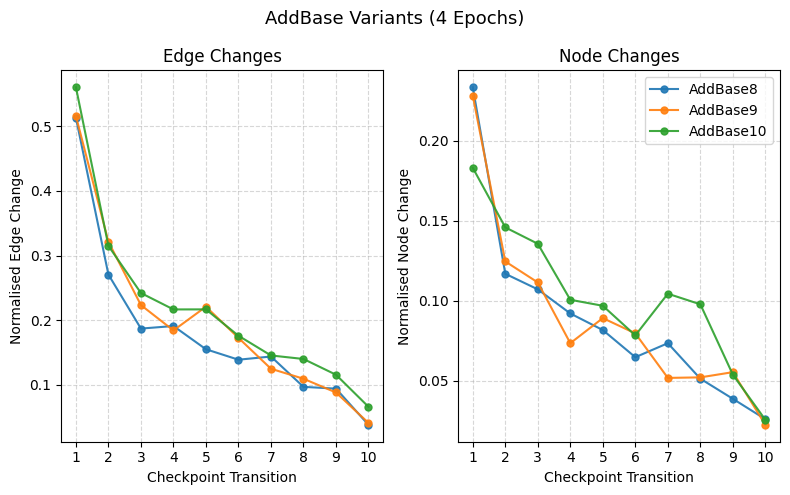

In [26]:
paths = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/AddSub',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/AddSubInv',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/CondAddSub']


visualize_fine_tunings(paths, custom_labels=['AddBase8','AddBase9','AddBase10'])

In [3]:
def calculate_total_edge_change_topk(checkpoints, topk_percent=0.05):
    if len(checkpoints) < 2:
        raise ValueError("Need at least two checkpoints to compute total edge change.")

    def topk_edges(edges, percent):
        k = max(1, int(len(edges) * percent))
        sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
        top_edges = set(edge for edge, data in sorted_edges[:k])
        return top_edges, k
    
    first_edges = checkpoints[1]['edges']
    last_edges = checkpoints[-1]['edges']

    first_top, k = topk_edges(first_edges, topk_percent)
    last_top, _ = topk_edges(last_edges, topk_percent)
    overlap = len(first_top & last_top)
    actual_changes = k - overlap
    normalized_change = actual_changes / k

    print(f"Total Change (first→last): Top-k Size={k}, Overlap={overlap}, "
          f"Changes={actual_changes}, Normalized={normalized_change:.3f}")

    return normalized_change


def calculate_total_edge_changes_for_dirs(dirs, topk_percent=0.05):
    results = {}
    for d in dirs:
        checkpoints = load_checkpoints_in_order(d)
        print(f"\nDirectory: {d}")
        results[d] = calculate_total_edge_change_topk(checkpoints, topk_percent)
    return results

In [12]:
def calculate_jaccard_topk(checkpoints, topk_percent=0.05):
    if len(checkpoints) < 2:
        raise ValueError("Need at least two checkpoints to compute Jaccard similarity.")

    def topk_edges(edges, percent):
        k = max(1, int(len(edges) * percent))
        sorted_edges = sorted(edges.items(), key=lambda item: abs(item[1].get('score', 0)), reverse=True)
        top_edges = set(edge for edge, data in sorted_edges[:k])
        return top_edges, k

    first_edges = checkpoints[1]['edges']
    last_edges = checkpoints[-1]['edges']

    first_top, _ = topk_edges(first_edges, topk_percent)
    last_top, _ = topk_edges(last_edges, topk_percent)

    intersection = first_top & last_top
    union = first_top | last_top
    jaccard_index = len(intersection) / len(union) if union else 0.0

    print(f"Jaccard Similarity (first→last): {jaccard_index:.3f}")
    return jaccard_index

def calculate_jaccard_for_dirs(dirs, topk_percent=0.05):
    results = {}
    for d in dirs:
        checkpoints = load_checkpoints_in_order(d)
        print(f"\nDirectory: {d}")
        results[d] = calculate_jaccard_topk(checkpoints, topk_percent)
    return results

In [13]:
dirs_08 = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase8',
               '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase9',
               '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase10']

dirs_2 = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase8',
               '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase9',
               '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase10']

# dirs_08= ['/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/AddSub',
#          '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/AddSubInv',
#          '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_2_epochs/CondAddSub']

# dirs_2= ['/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/AddSub',
#          '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/AddSubInv',
#          '/mnt/faster0/rje41/checkpoints/results/experiment_1/add_sub_08_epochs/CondAddSub']



results_08 = calculate_jaccard_for_dirs(dirs_08, topk_percent=0.10)
results_2 = calculate_jaccard_for_dirs(dirs_2, topk_percent=0.10)


Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase8
Jaccard Similarity (first→last): 0.451

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase9
Jaccard Similarity (first→last): 0.414

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase10
Jaccard Similarity (first→last): 0.430

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase8
Jaccard Similarity (first→last): 0.456

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase9
Jaccard Similarity (first→last): 0.442

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase10
Jaccard Similarity (first→last): 0.494


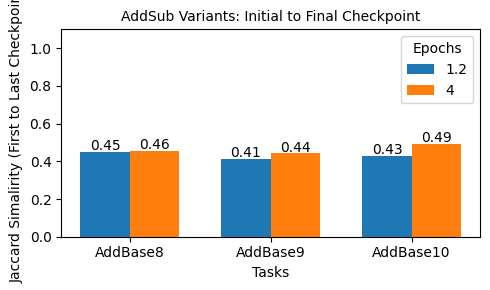

In [84]:
labels = [d.split("/")[-1] for d in results_08.keys()]
x = np.arange(len(labels))

values_08 = list(results_08.values())
values_2 = list(results_2.values())
width = 0.35  

plt.figure(figsize=(5, 3))
plt.bar(x - width/2, values_08, width, label="1.2")
plt.bar(x + width/2, values_2, width, label="4")

plt.ylabel("Jaccard Simalirity (First to Last Checkpoint)", fontsize=10)
plt.xlabel("Tasks", fontsize=10)
plt.title("AddSub Variants: Initial to Final Checkpoint", fontsize=10)
plt.xticks(x, labels, fontsize=10)

for i, v in enumerate(values_08):
    plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
for i, v in enumerate(values_2):
    plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.ylim(0, 1.1)
plt.legend(title="Epochs", fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.savefig('edge_changes_addbase_10_bar.pdf', format='pdf', dpi=600)
plt.show()

In [15]:
dirs_08 = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase8',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase9',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase10']


dirs_2 = ['/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase8',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase9',
         '/mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase10']


results_08 = calculate_total_edge_changes_for_dirs(dirs_08, topk_percent=0.05)
results_2 = calculate_total_edge_changes_for_dirs(dirs_2, topk_percent=0.05)



Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase8
Total Change (first→last): Top-k Size=11574, Overlap=6857, Changes=4717, Normalized=0.408

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase9
Total Change (first→last): Top-k Size=11574, Overlap=6410, Changes=5164, Normalized=0.446

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_1_2_epochs_small_ds/AddBase10
Total Change (first→last): Top-k Size=11574, Overlap=6630, Changes=4944, Normalized=0.427

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase8
Total Change (first→last): Top-k Size=11574, Overlap=6963, Changes=4611, Normalized=0.398

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1/base_4_epochs_small_ds/AddBase9
Total Change (first→last): Top-k Size=11574, Overlap=6889, Changes=4685, Normalized=0.405

Directory: /mnt/faster0/rje41/checkpoints/results/experiment_1

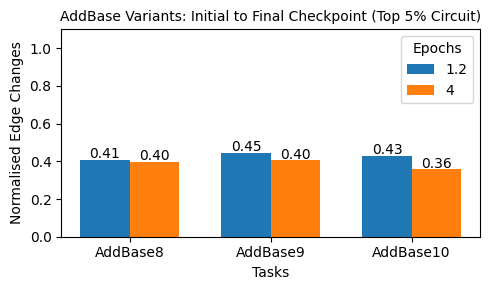

In [16]:
labels = [d.split("/")[-1] for d in results_08.keys()]
x = np.arange(len(labels))

values_08 = list(results_08.values())
values_2 = list(results_2.values())
width = 0.35  

plt.figure(figsize=(5, 3))
plt.bar(x - width/2, values_08, width, label="1.2")
plt.bar(x + width/2, values_2, width, label="4")

plt.ylabel("Normalised Edge Changes", fontsize=10)
plt.xlabel("Tasks", fontsize=10)
plt.title("AddBase Variants: Initial to Final Checkpoint (Top 5% Circuit)", fontsize=10)
plt.xticks(x, labels, fontsize=10)

for i, v in enumerate(values_08):
    plt.text(i - width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
for i, v in enumerate(values_2):
    plt.text(i + width/2, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)

plt.ylim(0, 1.1)
plt.legend(title="Epochs", fontsize=10, title_fontsize=10)
plt.tight_layout()
plt.savefig('edge_changes_addbase_5_bar.pdf', format='pdf', dpi=600)
plt.show()